In [1]:
import os
import keras
import pandas
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [2]:
# Define paths to dataset
path_to_test = "../data/raw/test.csv"
path_to_train = "../data/raw/train.csv"

# Validate paths to data
print(f"Path to test.csv -> {'VALID' if os.path.exists(path_to_test) else 'INVALID'}")
print(f"Path to train.csv -> {'VALID' if os.path.exists(path_to_train) else 'INVALID'}")

Path to test.csv -> VALID
Path to train.csv -> VALID


In [3]:
# Load csvs into DataFrame
test_df = pandas.read_csv(path_to_test)
train_df = pandas.read_csv(path_to_train)

In [4]:
# Show shape of dataset (rows x columns)
print(f"Test shape -> {test_df.shape}")
print(f"Train shape -> {train_df.shape}")

Test shape -> (2947, 563)
Train shape -> (7352, 563)


In [5]:
# Test for duplicates
print(f"Duplicates in test -> {test_df.duplicated().sum()}")
print(f"Duplicates in train -> {train_df.duplicated().sum()}")

Duplicates in test -> 0
Duplicates in train -> 0


In [6]:
# Check columns with duplicate labels
print(f"Duplicate columns in test -> {len(test_df.columns[test_df.T.duplicated().tolist()])}")
print(f"Duplicate columns in train -> {len(train_df.columns[train_df.T.duplicated().tolist()])}")

Duplicate columns in test -> 21
Duplicate columns in train -> 21


In [7]:
# Remove duplicates
test_df = test_df.drop(test_df.columns[test_df.T.duplicated().tolist()], axis = 1)
train_df = train_df.drop(train_df.columns[train_df.T.duplicated().tolist()], axis = 1)

In [8]:
# Re-check columns with duplicate labels
print(f"Duplicate columns in test -> {len(test_df.columns[test_df.T.duplicated().tolist()])}")
print(f"Duplicate columns in train -> {len(train_df.columns[train_df.T.duplicated().tolist()])}")

Duplicate columns in test -> 0
Duplicate columns in train -> 0


In [9]:
# Test for missing values
print(f"Missing data in test -> {test_df.isnull().sum()}\n")
print(f"Missing data in train -> {train_df.isnull().sum()}")

Missing data in test -> tBodyAcc-mean()-X       0
tBodyAcc-mean()-Y       0
tBodyAcc-mean()-Z       0
tBodyAcc-std()-X        0
tBodyAcc-std()-Y        0
                       ..
angle(X,gravityMean)    0
angle(Y,gravityMean)    0
angle(Z,gravityMean)    0
subject                 0
Activity                0
Length: 542, dtype: int64

Missing data in train -> tBodyAcc-mean()-X       0
tBodyAcc-mean()-Y       0
tBodyAcc-mean()-Z       0
tBodyAcc-std()-X        0
tBodyAcc-std()-Y        0
                       ..
angle(X,gravityMean)    0
angle(Y,gravityMean)    0
angle(Z,gravityMean)    0
subject                 0
Activity                0
Length: 542, dtype: int64


<Axes: xlabel='count', ylabel='Activity'>

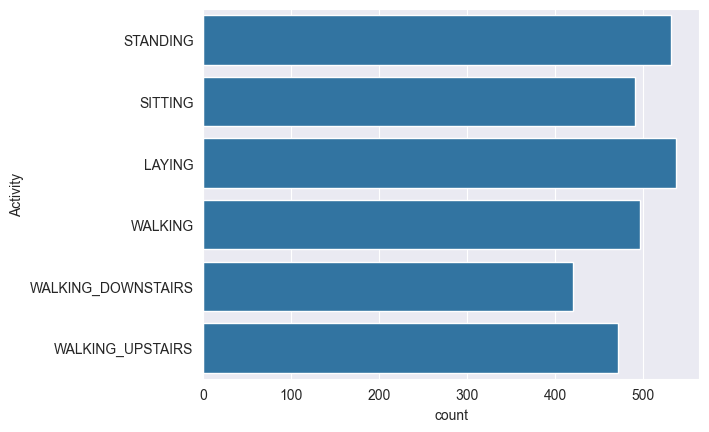

In [10]:
# Plot target label frequency (test)
sns.countplot(test_df['Activity'])

<Axes: xlabel='count', ylabel='Activity'>

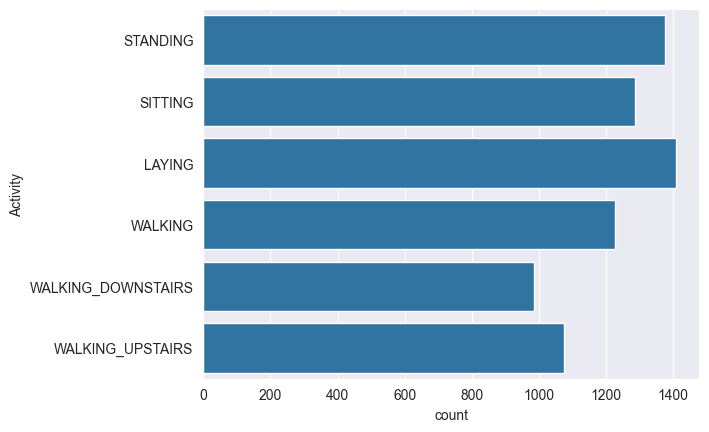

In [11]:
# Plot target label frequency (train)
sns.countplot(train_df['Activity'])

In [12]:
# Isolate features from target variable
target = train_df['Activity']
features = train_df.drop('Activity', axis = 1)

In [13]:
# Encode labels with LabelEncoder
label_encoder = LabelEncoder()
target = label_encoder.fit_transform(target)

In [14]:
# Partition dataset -> 80/20 split
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [15]:
# Normalize Features
scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

In [16]:
# Reshape data into 3D tensor, assuming that each sample represents unique moment in time
features_train = features_train.reshape(features_train.shape[0], 1, features_train.shape[1])
features_test = features_test.reshape(features_test.shape[0], 1, features_test.shape[1])

In [17]:
# Assemble RNN
model = keras.models.Sequential([
    # 64 processing cells, output full cell sequence
    keras.layers.LSTM(64, return_sequences = True, input_shape = (features_train.shape[1], features_train.shape[2])),

    # Randomly deactivate 20% of processing cells
    keras.layers.Dropout(0.2),

    # 32 processing cells, no output of cell sequence
    keras.layers.LSTM(32),

    # Randomly deactivate 20% of processing cells
    keras.layers.Dropout(0.2),

    # 32 neuron fully-connected dense layer, Rectified Linear Unit activation
    keras.layers.Dense(32, activation = 'relu'),

    # Output layer
    keras.layers.Dense(len(label_encoder.classes_), activation = 'softmax')
])

2025-03-16 17:41:21.984446: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-03-16 17:41:21.984637: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-16 17:41:21.984641: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1742161281.985126  367171 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1742161281.985190  367171 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/langtowl/miniconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the mode

In [25]:
# Save best model
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath = '../models/best_model.h5',
    monitor = 'val_loss',
    save_best_only = True,
    mode = 'min',
    verbose = 0
)

# Early stopping config
early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights = True,
    verbose = 0
)

In [26]:
# Compile Model
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [27]:
# Train Model
history = model.fit(features_train, target_train, epochs = 40, batch_size = 32, validation_data = (features_test, target_test), callbacks = [checkpoint], verbose = 2)

Epoch 1/40


184/184 - 4s - 24ms/step - accuracy: 0.9764 - loss: 0.0630 - val_accuracy: 0.9762 - val_loss: 0.0733
Epoch 2/40
184/184 - 3s - 16ms/step - accuracy: 0.9755 - loss: 0.0616 - val_accuracy: 0.9572 - val_loss: 0.1179
Epoch 3/40
184/184 - 3s - 16ms/step - accuracy: 0.9803 - loss: 0.0523 - val_accuracy: 0.9762 - val_loss: 0.0763
Epoch 4/40


184/184 - 3s - 16ms/step - accuracy: 0.9849 - loss: 0.0412 - val_accuracy: 0.9755 - val_loss: 0.0717
Epoch 5/40
184/184 - 3s - 17ms/step - accuracy: 0.9813 - loss: 0.0494 - val_accuracy: 0.9776 - val_loss: 0.0832
Epoch 6/40
184/184 - 3s - 16ms/step - accuracy: 0.9811 - loss: 0.0476 - val_accuracy: 0.9748 - val_loss: 0.0722
Epoch 7/40


184/184 - 3s - 16ms/step - accuracy: 0.9813 - loss: 0.0503 - val_accuracy: 0.9748 - val_loss: 0.0661
Epoch 8/40
184/184 - 3s - 16ms/step - accuracy: 0.9852 - loss: 0.0390 - val_accuracy: 0.9769 - val_loss: 0.0698
Epoch 9/40
184/184 - 3s - 16ms/step - accuracy: 0.9867 - loss: 0.0357 - val_accuracy: 0.9769 - val_loss: 0.0743
Epoch 10/40


184/184 - 3s - 17ms/step - accuracy: 0.9913 - loss: 0.0273 - val_accuracy: 0.9830 - val_loss: 0.0652
Epoch 11/40
184/184 - 3s - 16ms/step - accuracy: 0.9847 - loss: 0.0411 - val_accuracy: 0.9735 - val_loss: 0.0751
Epoch 12/40


184/184 - 3s - 17ms/step - accuracy: 0.9900 - loss: 0.0283 - val_accuracy: 0.9850 - val_loss: 0.0556
Epoch 13/40
184/184 - 3s - 16ms/step - accuracy: 0.9859 - loss: 0.0339 - val_accuracy: 0.9816 - val_loss: 0.0617
Epoch 14/40
184/184 - 3s - 16ms/step - accuracy: 0.9818 - loss: 0.0520 - val_accuracy: 0.9816 - val_loss: 0.0572
Epoch 15/40
184/184 - 3s - 16ms/step - accuracy: 0.9905 - loss: 0.0279 - val_accuracy: 0.9816 - val_loss: 0.0658
Epoch 16/40
184/184 - 3s - 16ms/step - accuracy: 0.9906 - loss: 0.0269 - val_accuracy: 0.9823 - val_loss: 0.0786
Epoch 17/40
184/184 - 3s - 16ms/step - accuracy: 0.9913 - loss: 0.0214 - val_accuracy: 0.9837 - val_loss: 0.0621
Epoch 18/40
184/184 - 3s - 16ms/step - accuracy: 0.9872 - loss: 0.0350 - val_accuracy: 0.9850 - val_loss: 0.0603
Epoch 19/40
184/184 - 3s - 16ms/step - accuracy: 0.9891 - loss: 0.0281 - val_accuracy: 0.9803 - val_loss: 0.0598
Epoch 20/40
184/184 - 3s - 16ms/step - accuracy: 0.9929 - loss: 0.0173 - val_accuracy: 0.9850 - val_loss: 0.

184/184 - 3s - 16ms/step - accuracy: 0.9935 - loss: 0.0181 - val_accuracy: 0.9857 - val_loss: 0.0544
Epoch 26/40


184/184 - 3s - 16ms/step - accuracy: 0.9947 - loss: 0.0182 - val_accuracy: 0.9878 - val_loss: 0.0521
Epoch 27/40
184/184 - 3s - 16ms/step - accuracy: 0.9932 - loss: 0.0204 - val_accuracy: 0.9830 - val_loss: 0.0623
Epoch 28/40
184/184 - 3s - 16ms/step - accuracy: 0.9934 - loss: 0.0170 - val_accuracy: 0.9871 - val_loss: 0.0539
Epoch 29/40
184/184 - 3s - 16ms/step - accuracy: 0.9947 - loss: 0.0145 - val_accuracy: 0.9830 - val_loss: 0.0541
Epoch 30/40


184/184 - 3s - 16ms/step - accuracy: 0.9971 - loss: 0.0088 - val_accuracy: 0.9864 - val_loss: 0.0502
Epoch 31/40


184/184 - 3s - 16ms/step - accuracy: 0.9923 - loss: 0.0211 - val_accuracy: 0.9837 - val_loss: 0.0499
Epoch 32/40
184/184 - 3s - 16ms/step - accuracy: 0.9981 - loss: 0.0069 - val_accuracy: 0.9864 - val_loss: 0.0659
Epoch 33/40
184/184 - 3s - 16ms/step - accuracy: 0.9923 - loss: 0.0190 - val_accuracy: 0.9823 - val_loss: 0.0593
Epoch 34/40
184/184 - 3s - 16ms/step - accuracy: 0.9935 - loss: 0.0173 - val_accuracy: 0.9850 - val_loss: 0.0653
Epoch 35/40
184/184 - 3s - 16ms/step - accuracy: 0.9947 - loss: 0.0146 - val_accuracy: 0.9864 - val_loss: 0.0580
Epoch 36/40
184/184 - 3s - 16ms/step - accuracy: 0.9942 - loss: 0.0168 - val_accuracy: 0.9857 - val_loss: 0.0554
Epoch 37/40
184/184 - 3s - 16ms/step - accuracy: 0.9957 - loss: 0.0150 - val_accuracy: 0.9850 - val_loss: 0.0584
Epoch 38/40
184/184 - 3s - 16ms/step - accuracy: 0.9956 - loss: 0.0127 - val_accuracy: 0.9823 - val_loss: 0.0617
Epoch 39/40
184/184 - 3s - 16ms/step - accuracy: 0.9939 - loss: 0.0169 - val_accuracy: 0.9803 - val_loss: 0.

In [28]:
# Evaluate Model
test_loss, test_acc = model.evaluate(features_test, target_test)
print(f"Test Accuracy: {test_acc:.4f}")

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9902 - loss: 0.0335
Test Accuracy: 0.9850
